# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

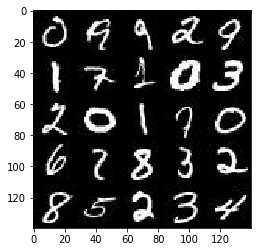

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

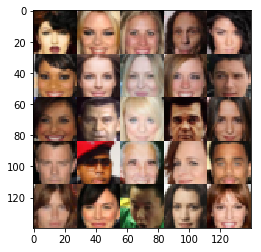

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name = "learning_rate")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse): # finish this
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', use_bias=False)
        x1 = tf.maximum(x1 * alpha, x1)
        # now 14x14x128
        
        # Hidden layer 2
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding ='same',use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha *x2, x2)
        # now 7x7x256
        
        # Hidden layer 3
        x3 = tf.layers.conv2d(x2, 512, 5, strides=1, padding ='same', use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha *x3, x3)
        #now 7x7x512
        #print ('x3', x3)
        
        # flatten
        flat = tf.reshape(x3, (-1,7*7*512))
        
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # reshape to convolutional 
        x1 = tf.reshape(x1,(-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # now 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # now 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # now 14x14x128
            
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #print(input_real, input_z, lr)
    #print(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    #print(d_loss, g_loss)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    #print(d_opt, g_opt)
    
    steps = 0
    print_every = 20
    show_every = 100
    n_images = 25
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
                       
            for batch_images in get_batches(batch_size):
                #print (batch_images[0], batch_images[1],batch_images[2],batch_images[3])
                steps += 1
                batch_images = batch_images*2
                
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(tf.shape(batch_z))
            
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
            
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
            
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0901... Generator Loss: 6.2517
Epoch 1/2... Discriminator Loss: 0.0400... Generator Loss: 8.5012
Epoch 1/2... Discriminator Loss: 5.2576... Generator Loss: 9.8400
Epoch 1/2... Discriminator Loss: 2.7606... Generator Loss: 6.4040
Epoch 1/2... Discriminator Loss: 2.0447... Generator Loss: 5.7296


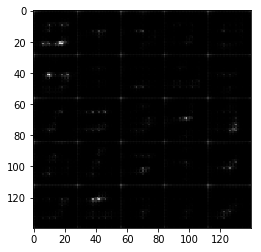

Epoch 1/2... Discriminator Loss: 2.7272... Generator Loss: 0.5667
Epoch 1/2... Discriminator Loss: 2.1130... Generator Loss: 0.5434
Epoch 1/2... Discriminator Loss: 2.0015... Generator Loss: 0.3359
Epoch 1/2... Discriminator Loss: 2.3637... Generator Loss: 0.1923
Epoch 1/2... Discriminator Loss: 1.7354... Generator Loss: 2.7662


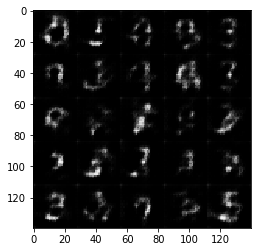

Epoch 1/2... Discriminator Loss: 2.1716... Generator Loss: 3.1184
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 2.6349... Generator Loss: 0.1810
Epoch 1/2... Discriminator Loss: 1.9850... Generator Loss: 3.2501
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.7495


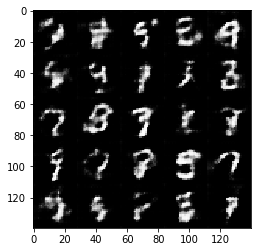

Epoch 1/2... Discriminator Loss: 1.7779... Generator Loss: 0.3669
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.9230
Epoch 1/2... Discriminator Loss: 1.6299... Generator Loss: 2.3160
Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.4535
Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.4791


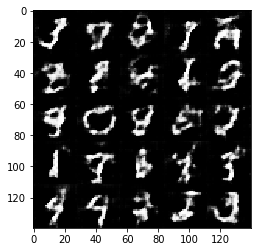

Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 1.8265
Epoch 1/2... Discriminator Loss: 1.8739... Generator Loss: 2.5037
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.6392
Epoch 1/2... Discriminator Loss: 1.5793... Generator Loss: 0.6489


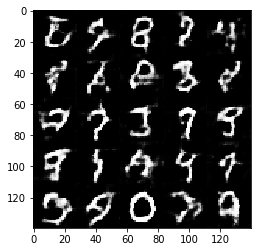

Epoch 1/2... Discriminator Loss: 1.7149... Generator Loss: 3.1557
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 1.7736... Generator Loss: 2.4139
Epoch 1/2... Discriminator Loss: 1.7984... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 2.2945... Generator Loss: 0.1655


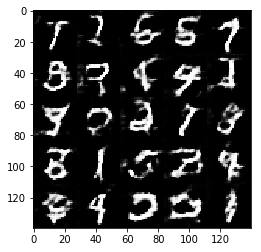

Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 1.6201
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 1.4895
Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 1.8159... Generator Loss: 0.2919


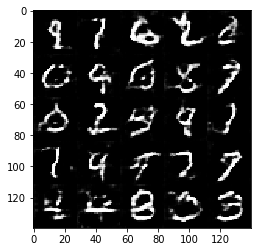

Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.5080
Epoch 1/2... Discriminator Loss: 1.8344... Generator Loss: 2.6677
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 1.3617
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 1.9087


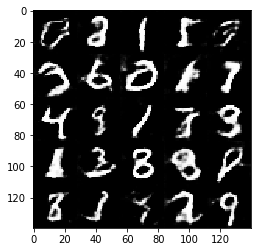

Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.4145
Epoch 1/2... Discriminator Loss: 1.5660... Generator Loss: 2.0749
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.5893
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 1.5503


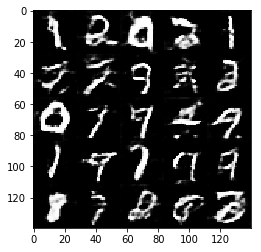

Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 1.6684
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.5905
Epoch 2/2... Discriminator Loss: 1.1621... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 1.5087
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 0.7794


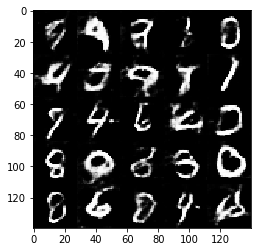

Epoch 2/2... Discriminator Loss: 2.7439... Generator Loss: 0.1129
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 1.2493
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 2.8196
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.7083


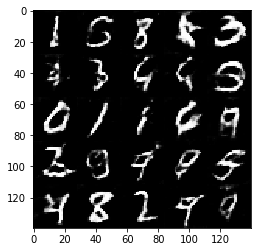

Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.3314
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.3144


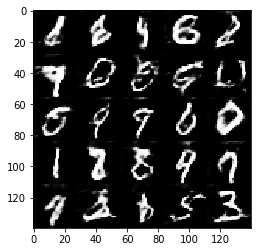

Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 1.3167
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 1.5605
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.7841... Generator Loss: 0.3253


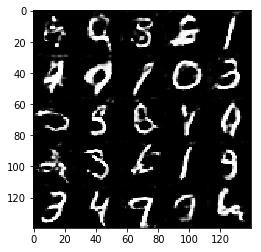

Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 2.9852
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 2.2668... Generator Loss: 0.1692
Epoch 2/2... Discriminator Loss: 1.8461... Generator Loss: 0.3284
Epoch 2/2... Discriminator Loss: 1.4671... Generator Loss: 2.8745


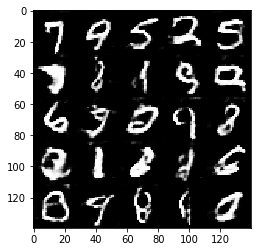

Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.5890
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 0.8637
Epoch 2/2... Discriminator Loss: 1.6535... Generator Loss: 2.6084
Epoch 2/2... Discriminator Loss: 2.5038... Generator Loss: 3.6557
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.5249


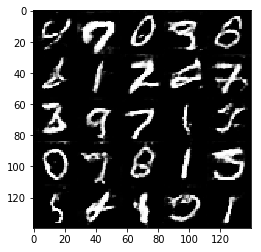

Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 1.8616
Epoch 2/2... Discriminator Loss: 1.8431... Generator Loss: 0.2816
Epoch 2/2... Discriminator Loss: 1.8383... Generator Loss: 0.4333
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 2.2074


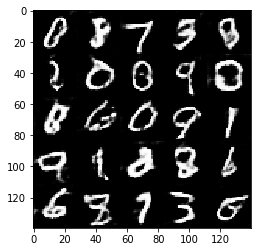

Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 1.2231
Epoch 2/2... Discriminator Loss: 1.6231... Generator Loss: 2.5669
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 2.3699
Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.0700


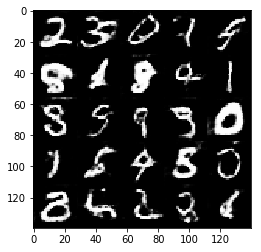

Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 1.0662
Epoch 2/2... Discriminator Loss: 2.3061... Generator Loss: 3.8495
Epoch 2/2... Discriminator Loss: 1.6000... Generator Loss: 2.7702
Epoch 2/2... Discriminator Loss: 1.6266... Generator Loss: 0.3358
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 2.2491


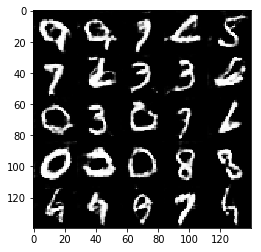

Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.4720
Epoch 2/2... Discriminator Loss: 6.4188... Generator Loss: 0.0819
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 2.4595


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 7.2694
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 2.7352
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 6.4773
Epoch 1/1... Discriminator Loss: 1.8406... Generator Loss: 0.3018


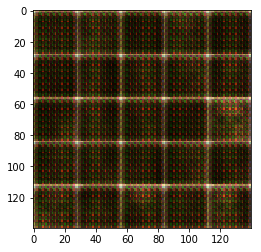

Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 4.0996
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 3.4133
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8436


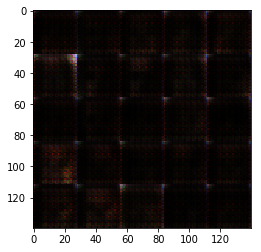

Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 2.3453
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 1.9021... Generator Loss: 4.6753


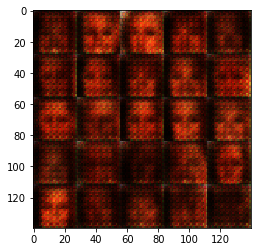

Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.6830
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 1.5142


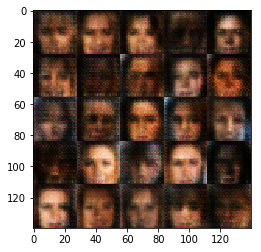

Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 1.4941


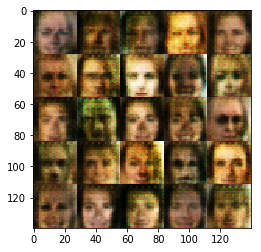

Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 1.8443
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.4490


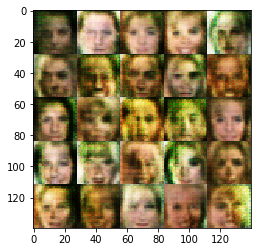

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 2.4713
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.7369... Generator Loss: 2.1125


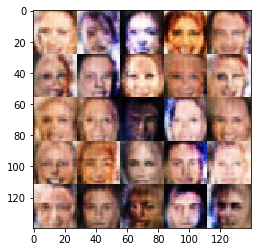

Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.5007
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.7018
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.2294
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.4373


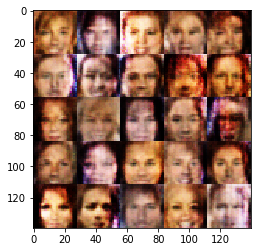

Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 2.0867
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 1.9282


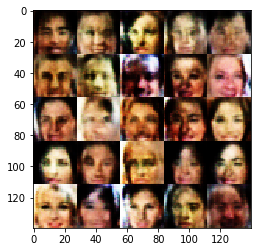

Epoch 1/1... Discriminator Loss: 0.1389... Generator Loss: 3.3194
Epoch 1/1... Discriminator Loss: 0.2198... Generator Loss: 3.8651
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 1.3796


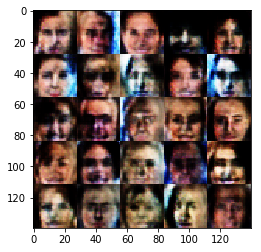

Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 5.1336
Epoch 1/1... Discriminator Loss: 6.3113... Generator Loss: 6.7414
Epoch 1/1... Discriminator Loss: 0.1600... Generator Loss: 3.8807
Epoch 1/1... Discriminator Loss: 0.2009... Generator Loss: 3.3590
Epoch 1/1... Discriminator Loss: 0.1676... Generator Loss: 2.3306


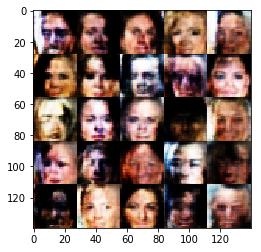

Epoch 1/1... Discriminator Loss: 0.1648... Generator Loss: 4.4624
Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 7.8301
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 3.5569
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.7752
Epoch 1/1... Discriminator Loss: 0.2577... Generator Loss: 2.4389


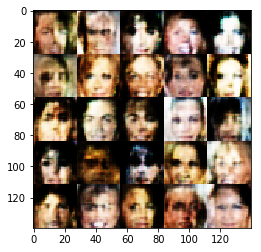

Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 2.1973
Epoch 1/1... Discriminator Loss: 0.1745... Generator Loss: 2.9757
Epoch 1/1... Discriminator Loss: 0.3159... Generator Loss: 2.0370
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 4.5247
Epoch 1/1... Discriminator Loss: 0.2539... Generator Loss: 2.0448


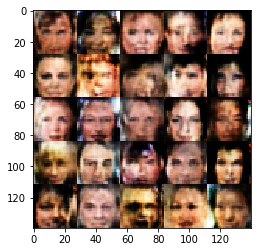

Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 8.5827
Epoch 1/1... Discriminator Loss: 2.7818... Generator Loss: 0.1216
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 2.0209
Epoch 1/1... Discriminator Loss: 0.2902... Generator Loss: 1.8348
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 1.6147


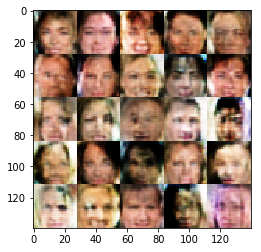

Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 2.9619
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 3.1918
Epoch 1/1... Discriminator Loss: 0.2091... Generator Loss: 4.3942
Epoch 1/1... Discriminator Loss: 0.1951... Generator Loss: 2.5204
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 4.4975


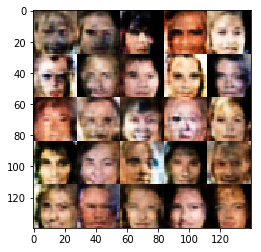

Epoch 1/1... Discriminator Loss: 0.0861... Generator Loss: 3.5963
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 7.6433
Epoch 1/1... Discriminator Loss: 0.2263... Generator Loss: 2.0689
Epoch 1/1... Discriminator Loss: 2.1792... Generator Loss: 3.7757


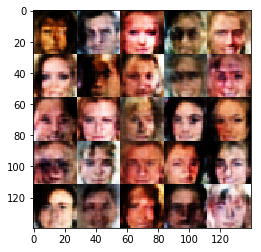

Epoch 1/1... Discriminator Loss: 0.3061... Generator Loss: 2.5472
Epoch 1/1... Discriminator Loss: 0.2223... Generator Loss: 5.1345
Epoch 1/1... Discriminator Loss: 2.7905... Generator Loss: 4.8341
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 2.3969


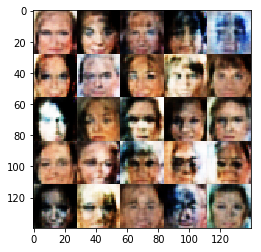

Epoch 1/1... Discriminator Loss: 0.2472... Generator Loss: 2.2910
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 5.8161
Epoch 1/1... Discriminator Loss: 2.6654... Generator Loss: 4.6976
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.8728


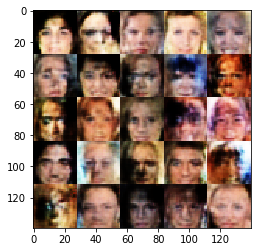

Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 1.4647
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 3.6402
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 5.6286
Epoch 1/1... Discriminator Loss: 0.1266... Generator Loss: 2.9380
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.0590


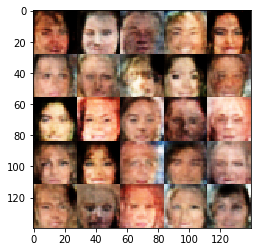

Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 5.0688
Epoch 1/1... Discriminator Loss: 0.2574... Generator Loss: 1.9913
Epoch 1/1... Discriminator Loss: 0.2025... Generator Loss: 2.3574
Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 4.0361


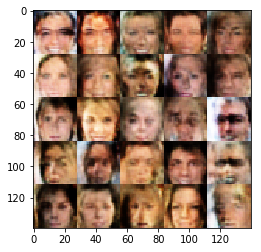

Epoch 1/1... Discriminator Loss: 2.0137... Generator Loss: 4.2406
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 0.1981... Generator Loss: 4.4627
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 1.2079
Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 3.5106


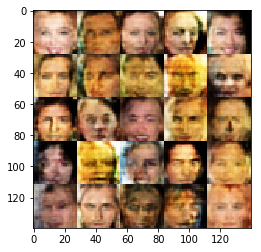

Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 5.6450
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 2.2346
Epoch 1/1... Discriminator Loss: 1.6846... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 4.1239
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 6.1967


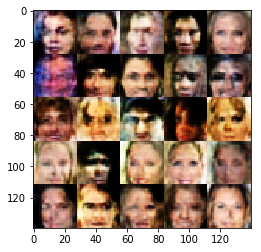

Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 6.3713
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 3.9310
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 3.9857
Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 4.4325
Epoch 1/1... Discriminator Loss: 0.1063... Generator Loss: 3.9518


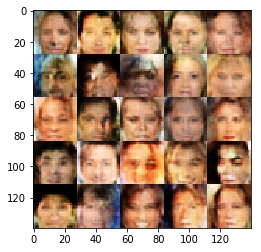

Epoch 1/1... Discriminator Loss: 0.3189... Generator Loss: 1.8813
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 6.0408
Epoch 1/1... Discriminator Loss: 0.2085... Generator Loss: 3.1211
Epoch 1/1... Discriminator Loss: 0.2907... Generator Loss: 4.9217
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 1.8179


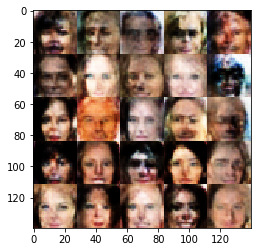

Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 3.6731
Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 3.7767
Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 6.1537
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 2.6049
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 1.9117


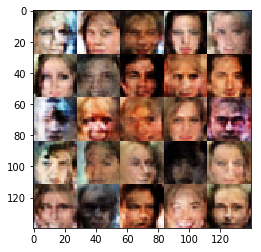

Epoch 1/1... Discriminator Loss: 0.2078... Generator Loss: 2.1309
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.5205
Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 4.0229
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 7.3057
Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 4.6943


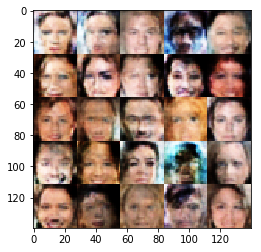

Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 2.9972
Epoch 1/1... Discriminator Loss: 0.3168... Generator Loss: 2.0398
Epoch 1/1... Discriminator Loss: 0.1394... Generator Loss: 3.1958
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 5.4873
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 4.2303


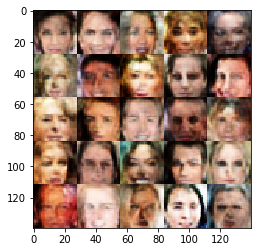

Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 1.7412
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 4.4796
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 3.1831
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 5.1812


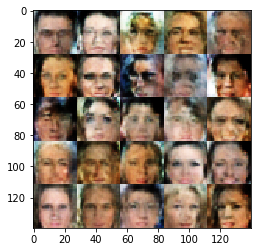

Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 4.0732
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 4.3392
Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 4.9424
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 6.5359
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 4.3346


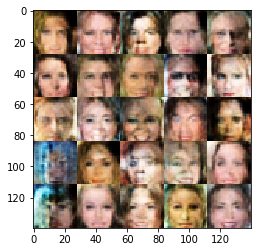

Epoch 1/1... Discriminator Loss: 0.0375... Generator Loss: 4.2321
Epoch 1/1... Discriminator Loss: 0.0439... Generator Loss: 4.2953
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 4.1793
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 3.0727
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.5417


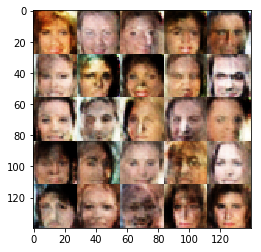

Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 2.1803
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 3.0863
Epoch 1/1... Discriminator Loss: 0.2143... Generator Loss: 5.3157
Epoch 1/1... Discriminator Loss: 0.2216... Generator Loss: 2.5582


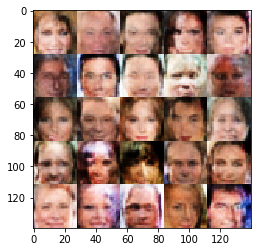

Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 5.1928
Epoch 1/1... Discriminator Loss: 1.9490... Generator Loss: 4.9525


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.